In [2]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import requests

In [3]:
%%capture
%run -i -e main.ipynb

In [11]:
selected_clusters = pd.DataFrame(DBSCAN_cluster.copy())
selected_clusters

,Cluster,Stock,Stock_Name
0,0,AEE,Ameren
1,0,AEP,American Electric Power
2,0,ATO,Atmos Energy
3,0,AWK,American Water Works
4,0,CMS,CMS Energy
5,0,D,Dominion Energy
6,0,DTE,DTE Energy
7,0,DUK,Duke Energy
8,0,ED,Consolidated Edison
9,0,ES,Eversource


In [14]:
selected_clusters.loc[selected_clusters["Cluster"] == 1, "Stock"]
selected_clusters["Cluster"].unique()

array([0, 1, 2, 3], dtype=int64)

In [15]:
corr = selected_clusters.corr()
pairs_list = set()

for i in selected_clusters["Cluster"].unique():
    for pair in combinations(selected_clusters.loc[selected_clusters["Cluster"] == i, "Stock"], 2):
        stock1, stock2 = pair
        correlation = abs(corr[stock1][stock2])
    
        if correlation > 0.9 and correlation != 1:
            coint = sm.tsa.coint(selected_clusters[stock1], selected_clusters[stock2])
        
            # Check if the cointegration test is significant
            if coint[1] < 0.01:
                pairs_list.add((stock1, stock2, correlation,1-coint[1]))

sorted_pairs_list = sorted(pairs_list, key=lambda x: x[3]*x[2], reverse=True)

# Take the top 10 pairs with the highest correlation
top_10_pairs = sorted_pairs_list[:10]

# Print or use the top 10 pairs
print("Top 10 pairs with highest correlation and cointegration:")
for pair in top_10_pairs:
    print(pair)


ValueError: could not convert string to float: 'AEE'

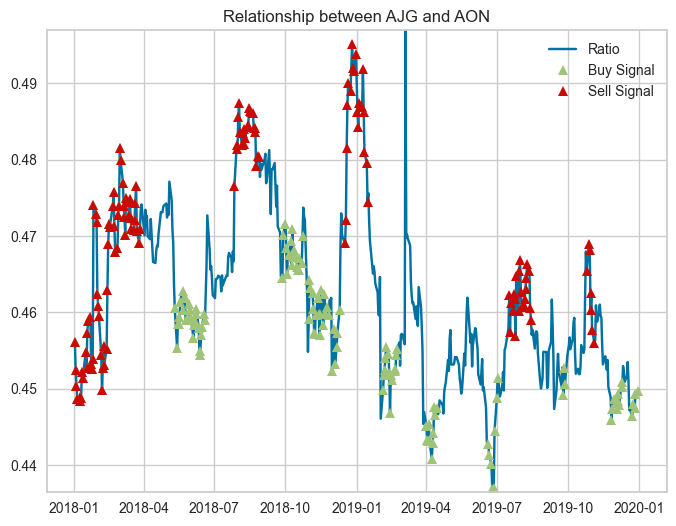

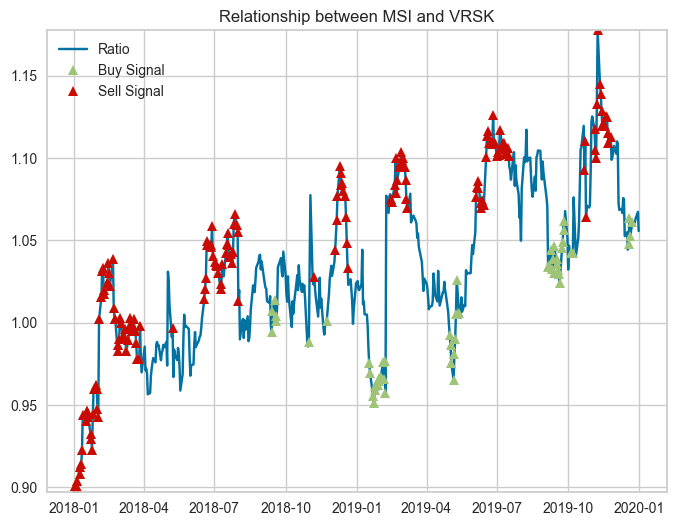

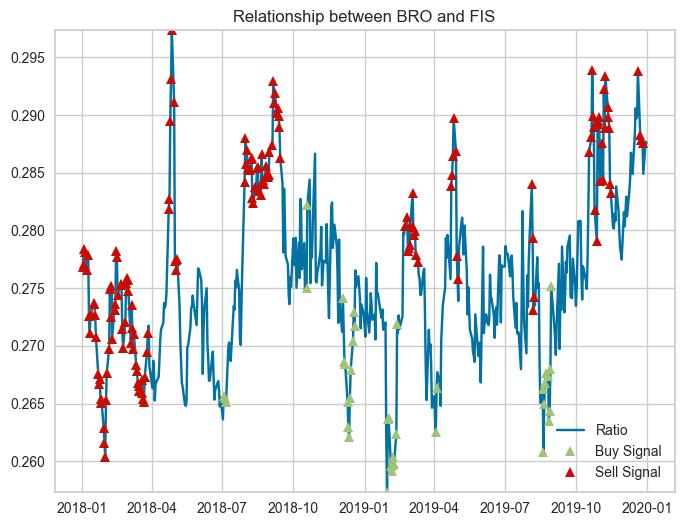

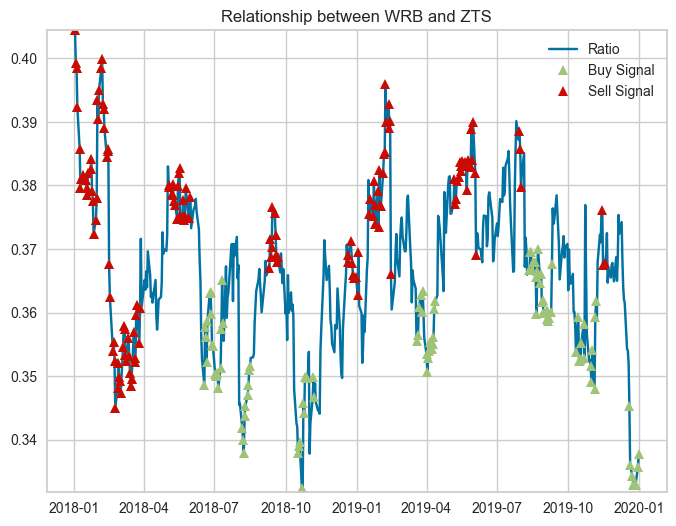

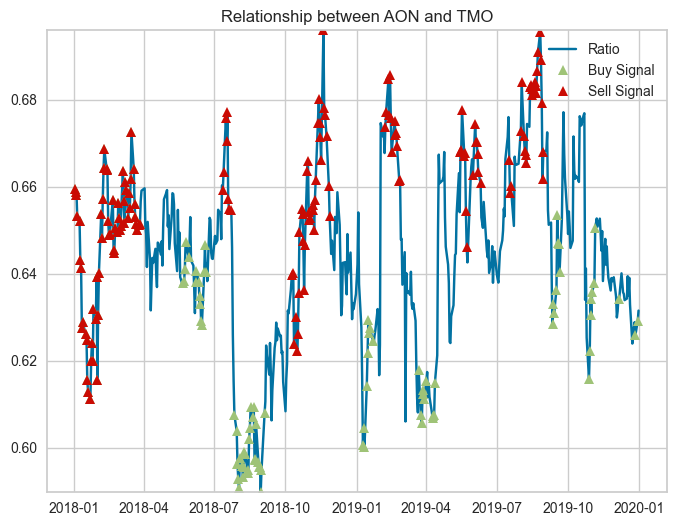

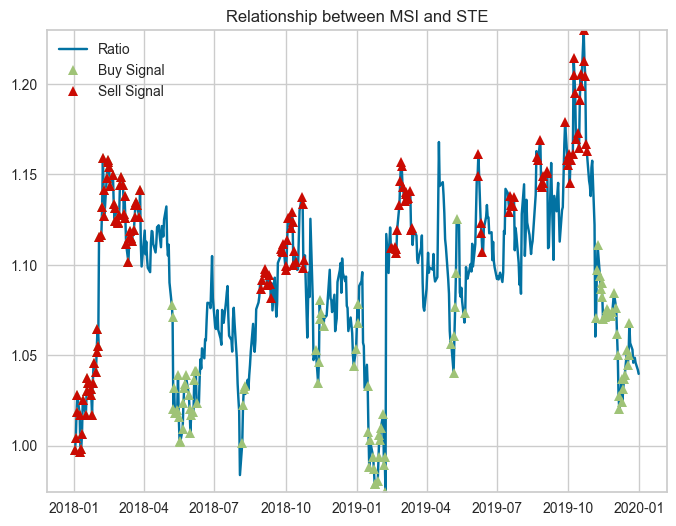

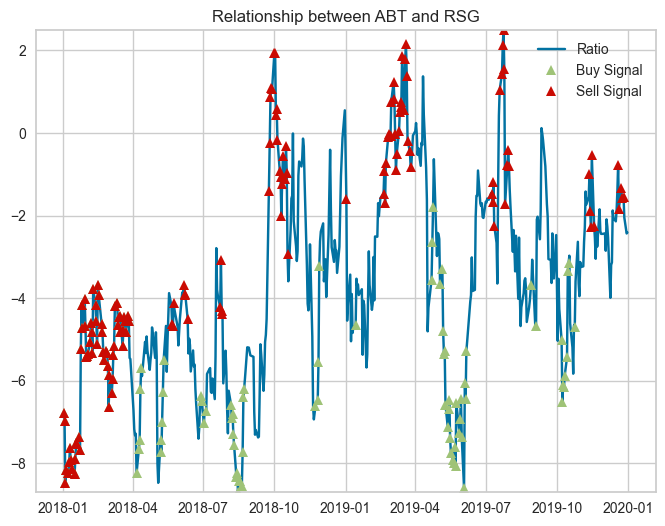

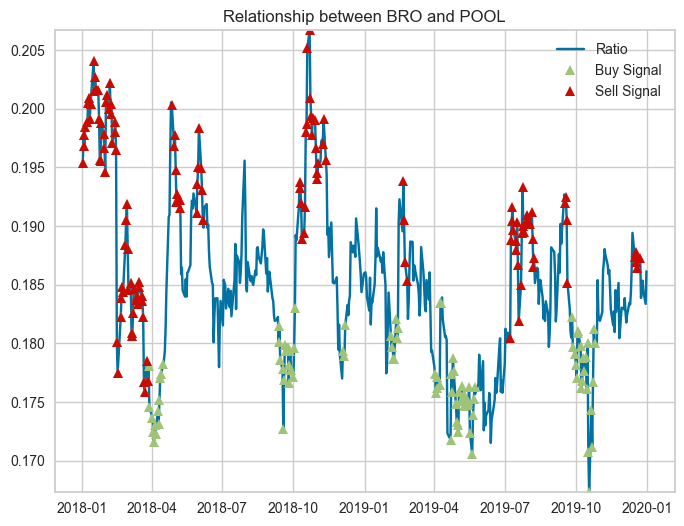

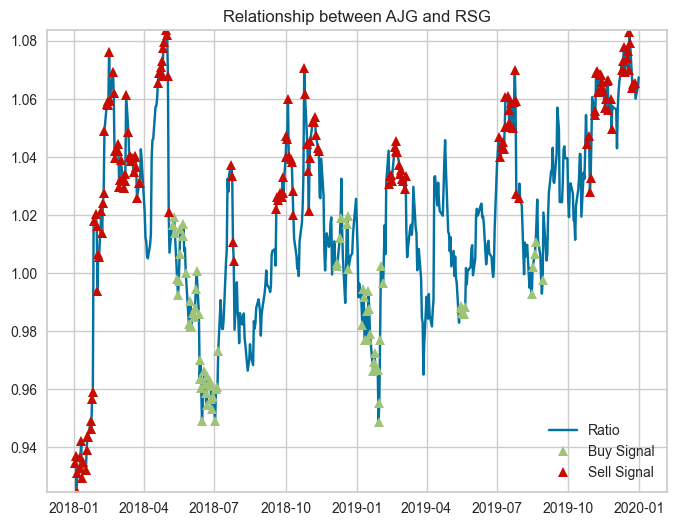

In [ ]:
for pair in top_10_pairs:
    # Cointgration test
    stock_1 = preferred_cluster[pair[0]]
    stock_2 = preferred_cluster[pair[1]]
    result = ts.coint(stock_1, stock_2)
    
    cointegration_t_statistic = result[0]
    p_val = result[1]
    critical_values_test_statistic_at_1_5_10 = result[2]
    
    if p_val < 0.05:
        # Dickey-Fuller Test
        first_ADF = adfuller(stock_1)
        second_ADF = adfuller(stock_2)
        Spread_ADF = adfuller(stock_1 - stock_2)
        Ratio_ADF = adfuller(stock_1 / stock_2)
        
        ratio, min_ratio = None, None

        if Spread_ADF[1] < Ratio_ADF[1]:
            ratio = stock_1 - stock_2
            min_ratio = Spread_ADF[1]
        elif Spread_ADF[1] > Ratio_ADF[1]:
            ratio = stock_1 / stock_2
            min_ratio = Ratio_ADF[1]

        if min_ratio < 0.05:
            # Create a signals
            ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
            ratios_mavg60 = ratio.rolling(window=60, center=False).mean()

            std_60 = ratio.rolling(window=60, center=False).std()
            zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

            plt.figure(figsize=(8, 6), dpi=100)
            plt.plot(ratio)
            buy = ratio.copy()
            sell = ratio.copy()
            buy[zscore_60_5>-1] = np.nan
            sell[zscore_60_5<1] = np.nan

            plt.plot(buy, color='g', linestyle='None', marker='^')
            plt.plot(sell, color='r', linestyle='None', marker='^')

            x1, x2, y1, y2 = plt.axis()
            plt.axis((x1, x2, ratio.min(), ratio.max()))
            plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
            plt.title(f'Relationship between {pair[0]} and {pair[1]}')
            plt.show()